In [1]:
from math import sin, cos
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import cv2
import csv
import warnings

import sys
import os
sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc

In [2]:
# Load obstacle data

data = np.genfromtxt('/home/oscar_palfelt/MSc_thesis/LearnedSamplingDistributions/narrowDataFile.txt', delimiter=',', usecols=range(27))
_, uniqueInd = np.unique(data[:,-4], return_index=True)
data = data[uniqueInd, :]

numEntries = data.shape[0]

obsData = data[:, 6:-12]

xyInitData = data[:,-12:-10]
yawInitData = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(numEntries,1)) # use random yaw
initData = np.concatenate((xyInitData, yawInitData), axis=1)

xyGoalData = data[:,-6:-4]
yawGoalData = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(numEntries,1)) # use random yaw
goalData = np.concatenate((xyGoalData, yawGoalData), axis=1)


In [3]:
# Generate occupancy grid

def isSampleFree(sample, obs):
    for o in list(range(0,obs.shape[0]//(2*dimW))): # python 2 -> 3: use list(), use //
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11

# process data into occupancy grid
occGrids = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = obsData[j,0:3]
    gap2 = obsData[j,3:6]
    gap3 = obsData[j,6:9]

    obs1 = [0, gap1[1]-dw, -0.5,          gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,          gap2[0], gap2[1], 1.5]
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5, gap2[0], 1, 1.5]
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5, gap3[0], gap1[1], 1.5]
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5, 1, gap1[1], 1.5]
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    occGrids[j,:] = occGrid

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000


In [50]:
# define planning problem

def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0
    else:
        return False

def propagate(start, control, duration, state):
    state.setX(start.getX() + v * duration * cos(start.getYaw()))
    state.setY(start.getY() + v * duration * sin(start.getYaw()))
    state.setYaw(start.getYaw() + control[0] * duration)


def problemDef():
    # construct the state space we are planning in
    space = ob.SE2StateSpace()

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # create a control space
    cspace = oc.RealVectorControlSpace(space, 1)

    # set the bounds for the control space
    cbounds = ob.RealVectorBounds(1)
    cbounds.setLow(-2.0)
    cbounds.setHigh(2.0)
    cspace.setBounds(cbounds)

    # define a simple setup class
    ss = oc.SimpleSetup(cspace)
    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))
    ss.setStatePropagator(oc.StatePropagatorFn(propagate))

    si = ss.getSpaceInformation()
    planner = oc.EST(si)
    ss.setPlanner(planner)

    si.setPropagationStepSize(.1)

    return ss


def plan(planObj, initState, goalState):

    space = ob.SE2StateSpace()

    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.2)

    planObj.solve(8.0)



         at line 77 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/src/SpaceInformation.cpp


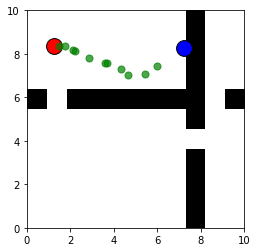

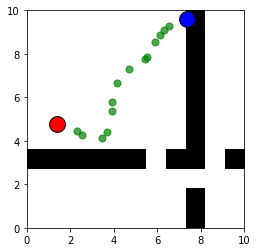

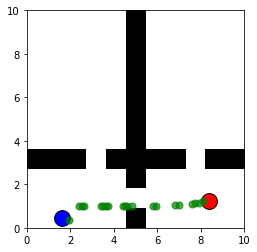

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


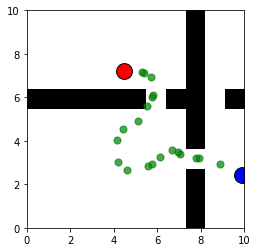

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


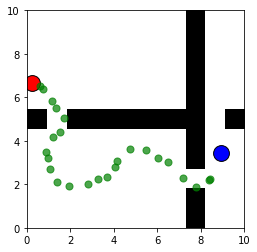

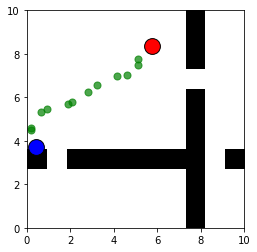

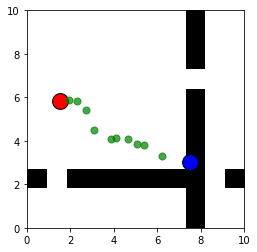

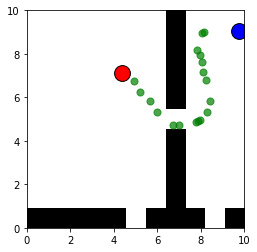

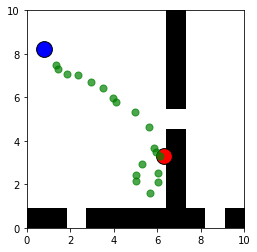

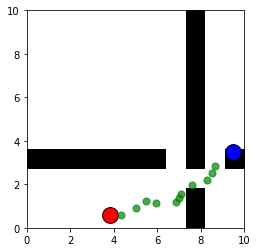


nPlans 10



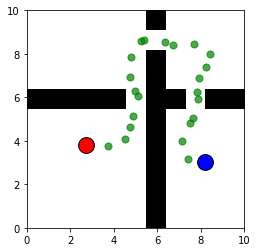

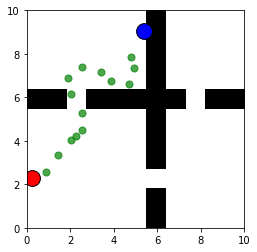

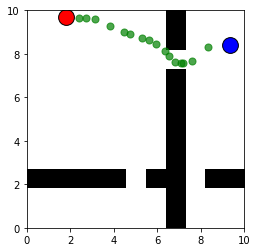

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


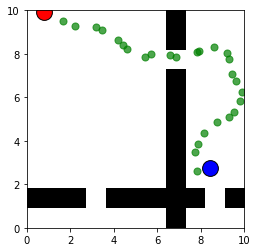

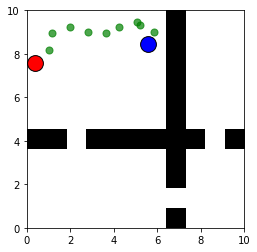

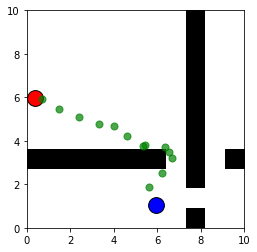

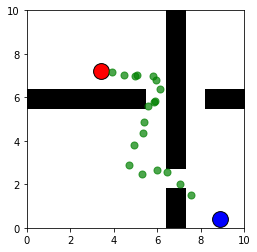

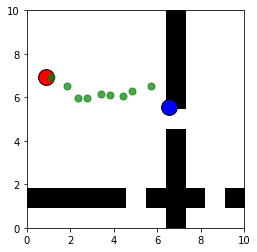

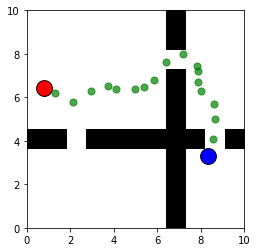

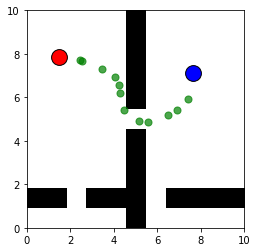


nPlans 20



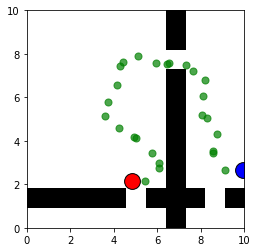

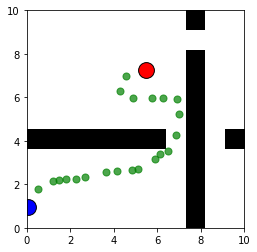

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


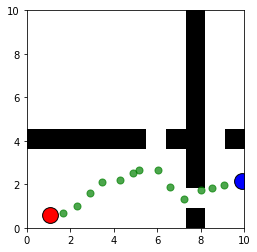

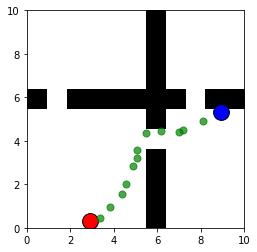

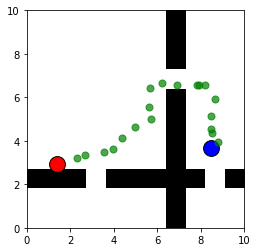

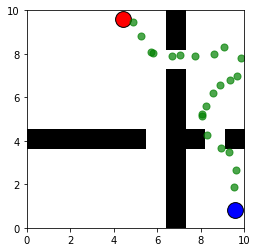

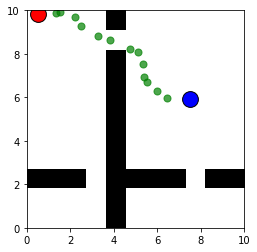

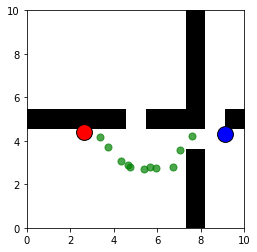

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


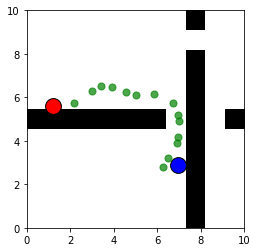

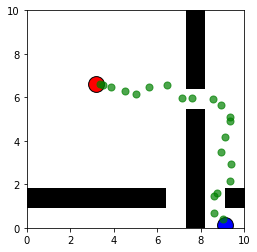


nPlans 30



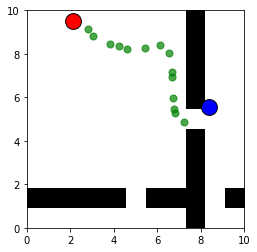

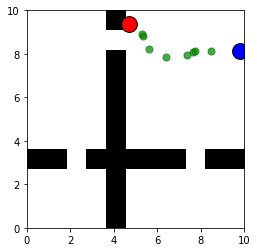

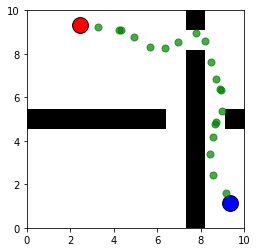

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


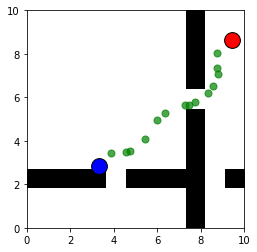

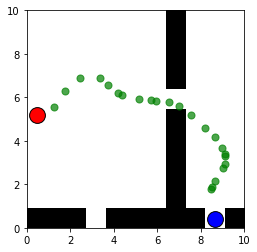

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


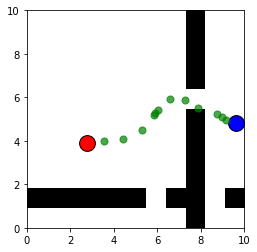

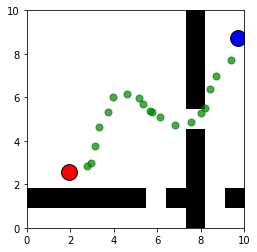

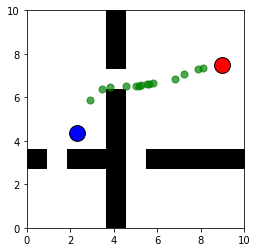

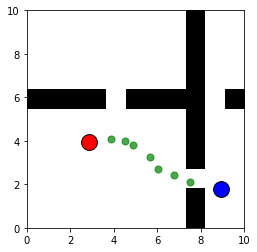

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


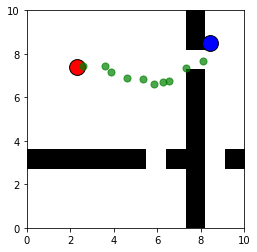


nPlans 40



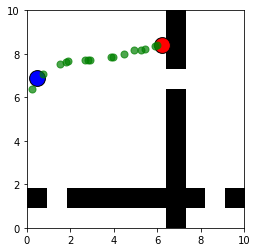

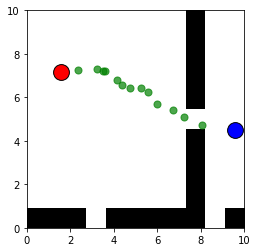

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp
         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


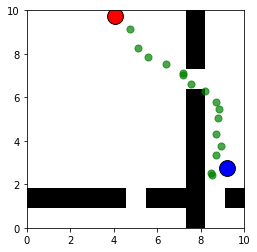

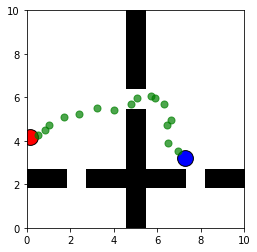

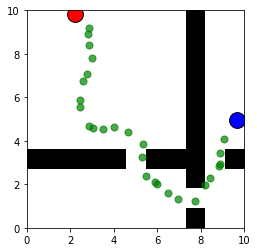

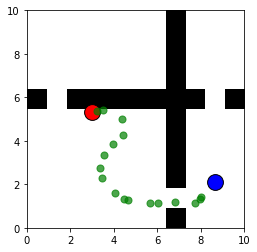

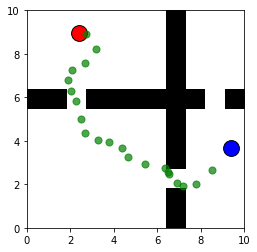

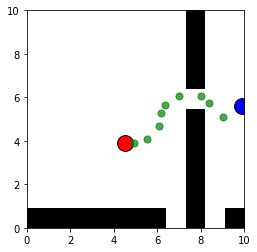

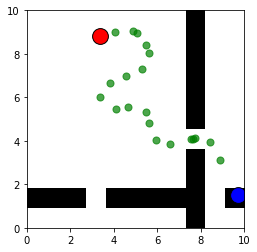

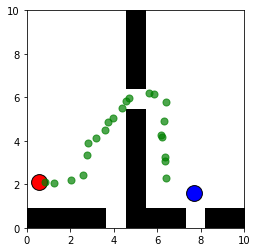


nPlans 50



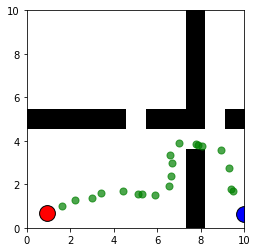

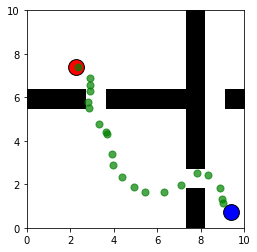

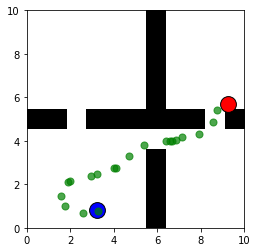

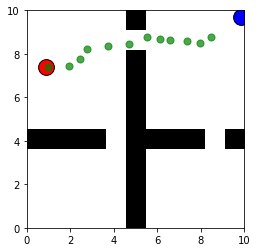

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


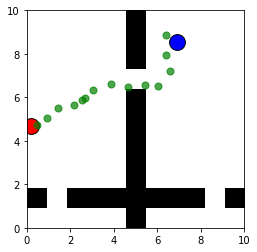

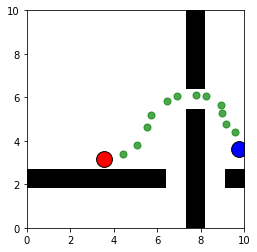

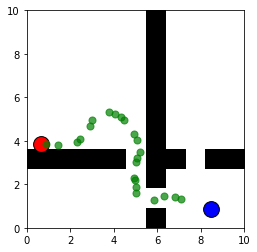

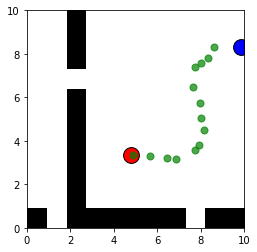

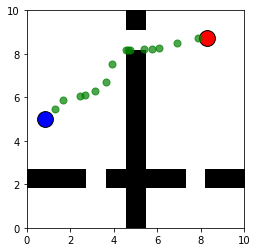

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


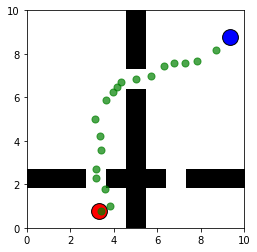


nPlans 60



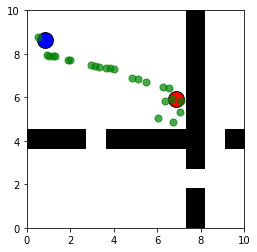

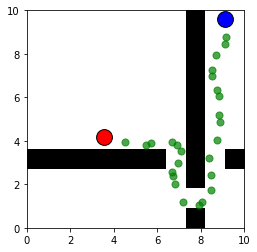

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


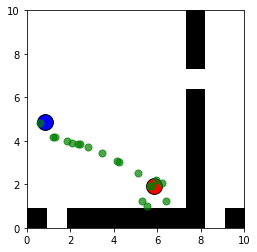

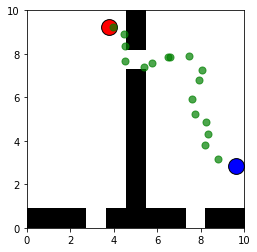

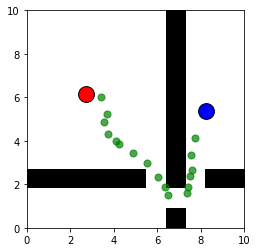

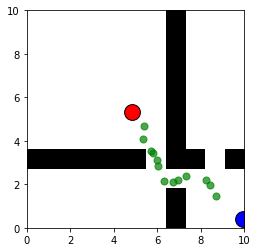

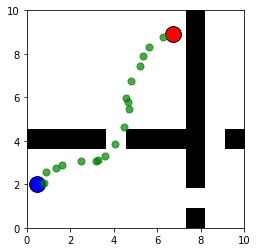

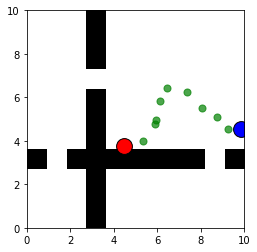

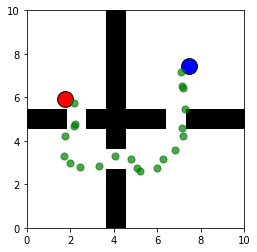

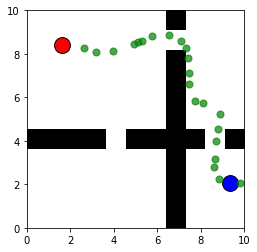


nPlans 70



         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


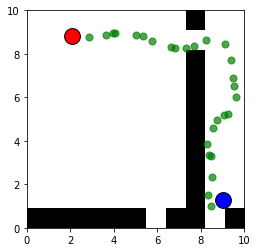

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


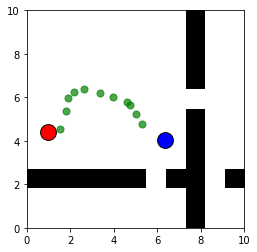

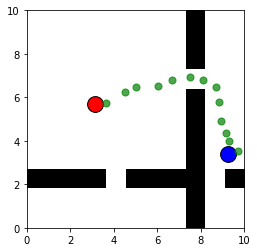

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


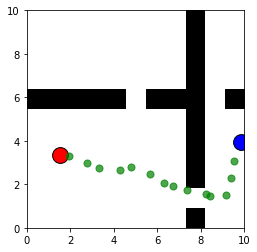

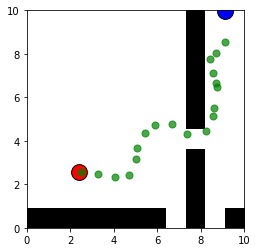

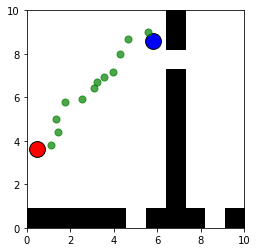

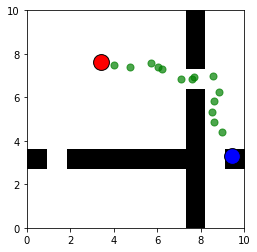

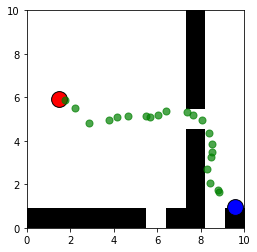

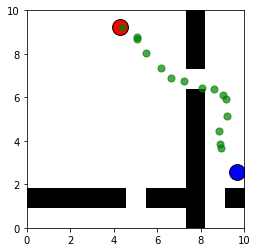

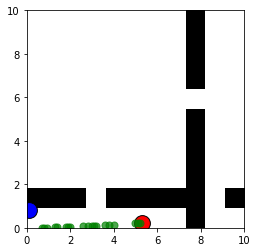


nPlans 80



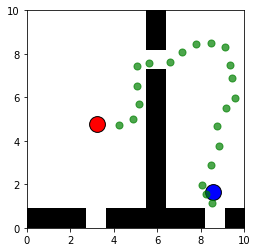

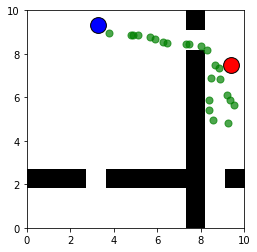

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp
         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


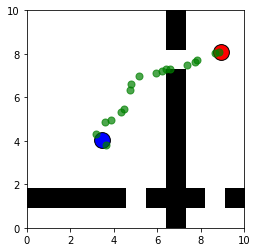

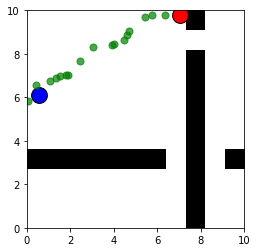

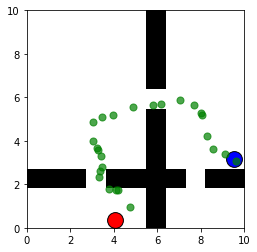

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


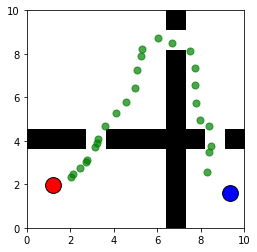

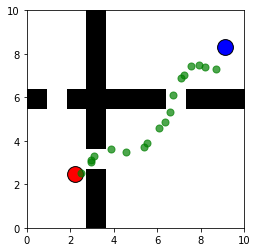

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   EST: There are no valid initial states!
         at line 111 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/est/src/EST.cpp


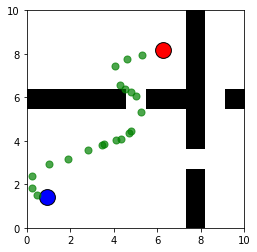

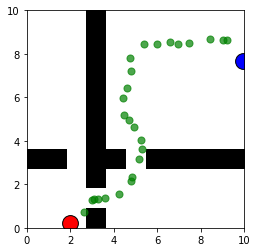

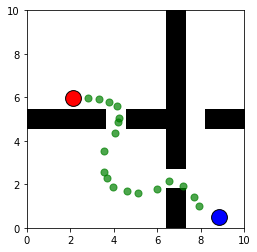


nPlans 90



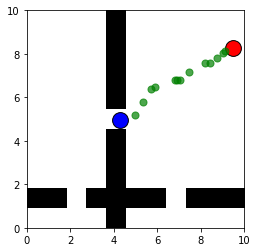

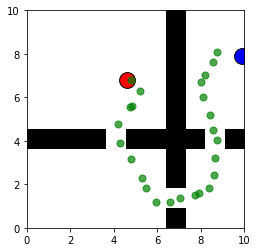

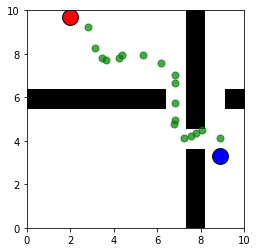

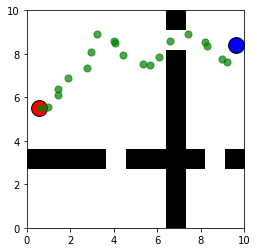

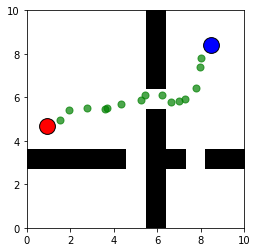

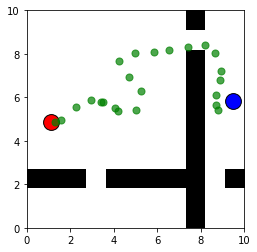

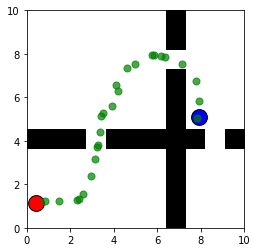

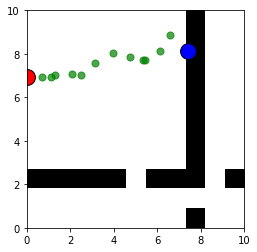

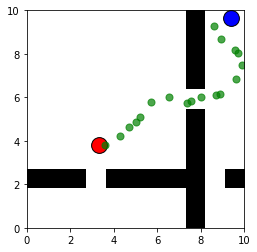

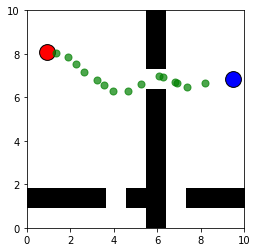


nPlans 100



In [55]:
# generate planning data, car scenario

nData = 3500 # number of maps to plan on, less or equal to numEntries

v = 0.1 # constant car velocity

pcSamplesPerPath = 0.8 # percentage of points in path to sample
trajSamples = np.zeros(shape=(1, 5)) # x, y, yaw, xdot, ydot
currentState = np.zeros(shape=(1, 3)) # x, y, yaw
newObsData = np.zeros(shape=(1, obsData.shape[1]))
newInitData = np.zeros(shape=(1, 5)) # x, y, yaw, xdot, ydot,
newGoalData = np.zeros(shape=(1, 5))

planObj = problemDef()
nAngles = 2 # number of initial/goal angles to attempt planning before deciding on the best plan
maxPathLen = 30
maxDist2Goal = 0.1

plotPaths = True

i = 0 
nPlans = 0
while nPlans < nData and i < numEntries-1:

    occGrid = np.rot90(occGrids[i].reshape(gridSize, gridSize)) # update map

    if initData[i,0] < goalData[i,0]:
        initData[i,-1] = 0
        goalData[i,-1] = 0
    else:
        initData[i,-1] = -np.pi
        goalData[i,-1] = -np.pi

    plan(planObj, initData[i,:], goalData[i,:])

    if planObj.haveSolutionPath():

        sol = np.loadtxt(StringIO(planObj.getSolutionPath().printAsMatrix()))
        
        if np.linalg.norm(goalData[i, 0:2] - sol[-1, 0:2]) < maxDist2Goal and sol.shape[0] < maxPathLen:
            sol = sol[1:-1,:-1] # discard first/last, time dimension

            nSamples = sol.shape[0]

            #nSamplesPerMap = int(pcSamplesPerPath * nSamples)
            #rndInd = np.random.choice(np.arange(start=1, stop=nSamples-1), size=nSamplesPerMap, replace=False)
            # sol = sol[rndInd, :]

            xdot = v * np.cos(sol[:,2]).reshape((nSamples,1))
            ydot = v * np.sin(sol[:,2]).reshape((nSamples,1))
            trajSamples = np.vstack((trajSamples, np.hstack((sol[:, 0:3], xdot, ydot)))) # x, y, yaw, xdot, ydot
            trajSamples[:,2] /= np.pi # normalize yaw
            newObsData = np.vstack((newObsData, np.tile(obsData[i], reps=(nSamples, 1))))
            newInitData = np.vstack((newInitData, np.tile(np.append(initData[i], [v * np.cos(initData[i,-1]), v * np.sin(initData[i,-1])]), reps=(nSamples, 1)))) # x, y, yaw, xdot, ydot
            newGoalData = np.vstack((newGoalData, np.tile(np.append(goalData[i], [v * np.cos(goalData[i,-1]), v * np.sin(goalData[i,-1])]), reps=(nSamples, 1)))) # x, y, yaw, xdot, ydot
            
            if plotPaths:
                fig, ax = plt.subplots()
                ax.imshow(occGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
                ax.scatter(initData[i,0] * (gridSize - 1), initData[i,1] * (gridSize - 1), color="red", s=250, edgecolors='black')
                ax.scatter(goalData[i,0] * (gridSize - 1), goalData[i,1] * (gridSize - 1), color="blue", s=250, edgecolors='black')
                ax.scatter(sol[:, 0] * (gridSize - 1), sol[:, 1] * (gridSize - 1), color="green", s=50, alpha=0.7)
                plt.show()

            nPlans += 1
            if nPlans % 10 == 0:
                print('\n nPlans {}\n'.format(nPlans))
            
  
    planObj.clear()
    i += 1  

newData = np.concatenate((trajSamples, newObsData, newInitData, newGoalData), axis=1)[1:]

fmt = '%1.6f', '%1.6f','%1.6f','%1.6f','%1.6f','%1.6f','%1.6f','%d','%1.6f','%1.6f','%d','%1.6f','%1.6f','%d','%1.6f','%1.6f','%1.6f','%1.6f','%1.6f','%1.6f','%1.6f','%1.6f','%1.6f','%1.6f'
np.savetxt('pathData3', newData, delimiter=',', fmt=fmt) # sample (5D), gap1 (2D, 1D orientation), gap2, gap3, init (5D), goal (5D)
